In [2]:
import xarray as xr
from dask.distributed import Client
import time
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import scipy 
sys.setrecursionlimit(100000)

In [3]:

#define your observation, forward simulation and da simulation root path
myobsroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/'
mynlroot = '/Volumes/WD_3/outputs_SCORRECTION/'
mypriorroot = '/Volumes/WD_3/roms4dvar_ecs/i4dvar_outputs/'
mypostroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/'
#define your workspace 
nl_workspace = 'outputs_201205/'
prior_workspace = 'workspace_sstbgqc/'
post_workspace = 'workspace_geopolarsst/'
obs_workspace = ''
#define your filenames
obs_file='sst_withcruiseptpkodc_2012_offshore.nc'
nl_files = "ocean_ecs_his_00*.nc"
#since this is a vertical profile validation, full fwd file is needed
prior_files = "STORAGE/prior/ocean_ecs_fwd_15461_outer0.nc"
posterior_files = "STORAGE/posterior/ocean_ecs_fwd_*.nc"

#
grd_file = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst/STORAGE/prior/ocean_ecs_fwd_15461_outer0.nc'


In [4]:
#define your target data duration

start_date = '2012-05-01-12H'
end_date = '2013-05-01-12H'

start_datetime = dt.datetime.strptime(start_date,"%Y-%m-%d-%HH")
end_datetime = dt.datetime.strptime(end_date,"%Y-%m-%d-%HH")
data_len = (end_datetime-start_datetime).days+1 

#define your target variable
obs_var = 6
# 2d situation
# model_var = 'temp_sur' 
#3d situation
model_var = 'temp'

# setting chunk size
x_chunk = int(262/2)
y_chunk = int(362/2)
z_chunk = 10

print('''duration to be validated: from %s to %s, total of %i days.
         target obs variable: %s
         target model variable: %s'''
      %(start_date,end_date,data_len,obs_var,model_var))



duration to be validated: from 2012-05-01-12H to 2013-05-01-12H, total of 366 days.
         target obs variable: 6
         target model variable: temp


In [5]:
# lauching the dask workstation
# client = Client()
# print(client.dashboard_link)

In [6]:
# client.close()

In [7]:
# loading observation data
Obs_ds = xr.open_dataset(myobsroot+obs_workspace+obs_file,
                           engine='netcdf4',
                           # chunks={'longitude':260,'latitude':210},
                           )

In [8]:
Obs_ds.obs_Xgrid.data

array([47.11647614, 48.44326034, 49.52159693, ..., 48.52137059,
       48.74770067, 49.4361546 ])

In [20]:
# extracting cruise observation data with specific time range 
start_obstime = (start_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24
end_obstime = (end_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24

this_range = np.where( 
                                (Obs_ds.obs_time.data >= start_obstime) &
                                (Obs_ds.obs_time.data <= end_obstime)  &
                                (Obs_ds.obs_provenance == 355)&
                                (Obs_ds.obs_type == obs_var)
                        )


Obs_ds = Obs_ds.isel(datum=this_range[0]).copy()
timestamp = [ dt.timedelta(itime)+dt.datetime(1970,1,1) for itime in Obs_ds.obs_time.data]
Obs_ds = Obs_ds.assign_coords(datum=timestamp).copy()
Obs_x = Obs_ds.obs_Xgrid.data[:]
Obs_y = Obs_ds.obs_Ygrid.data[:]

In [23]:
# loading forward sst
start = time.time()
fwd_ds = xr.open_mfdataset(mynlroot+nl_workspace+nl_files,
                                      engine='netcdf4',coords='minimal',
                                      parallel=True,
                                      # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                      #      's_rho':z_chunk, # only 3d needed
                                      #      'eta_u':y_chunk,'xi_u':x_chunk,\
                                      #      'eta_v':y_chunk,'xi_v':x_chunk,\
                                      #      'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                       )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))


loading costing 3.477380 min


In [ ]:
# loading prior sst
start = time.time()
prior_ds = xr.open_mfdataset(mypriorroot+prior_workspace+prior_files,
                             engine='netcdf4',coords='minimal',
                             parallel=True,
                             # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                             #             # 's_rho':z_chunk, # only 3d needed
                             #               'eta_u':y_chunk,'xi_u':x_chunk,\
                             #               'eta_v':y_chunk,'xi_v':x_chunk,\
                             #               'eta_psi':y_chunk,'xi_psi':x_chunk,},
                            )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))



In [ ]:
# loading poseterior sst
start = time.time()
post_ds = xr.open_mfdataset(mypostroot+post_workspace+posterior_files,
                                 engine='netcdf4',coords='minimal',
                                 parallel=True,
                                 # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                 #         # 's_rho':z_chunk, # only 3d needed
                                 #           'eta_u':y_chunk,'xi_u':x_chunk,\
                                 #           'eta_v':y_chunk,'xi_v':x_chunk,\
                                 #           'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                )#.chunk(dict(ocean_time=-1))

end = time.time()
print('loading costing %f min'%((end-start)/60))



In [25]:
Obs_data = Obs_ds.obs_value

In [24]:
# extracting forward sst with specific time range 
# for forward there is no qck file ,so the model var has only 'temp'
# further we only want the surface data, so the s_rho = -1
fwd_data = fwd_ds[model_var].sel(ocean_time=slice(start_date,end_date)).isel(s_rho=-1)
# always drop the initial time of posterior since there is a jump
fwd_data = fwd_data.drop_duplicates(dim='ocean_time',keep='first')
# fwd_data


In [ ]:
# extracting prior sst with specific time range 
prior_data = prior_ds[model_var].sel(ocean_time=slice(start_date,end_date)).isel(s_rho=-1)
# always drop the initial time of posterior since there is a jump
prior_data = prior_data.drop_duplicates(dim='ocean_time',keep='first')
# prior_data

In [ ]:
# extracting poseterior sst  with specific time range 
post_data = post_ds[model_var].sel(ocean_time=slice(start_date,end_date)).isel(s_rho=-1)
# always drop the initial time of posterior since there is a jump
post_data = post_data.drop_duplicates(dim='ocean_time',keep='first')
# post_data

In [26]:
data_modgrd = np.full([data_len,len(fwd_data.eta_rho),len(fwd_data.xi_rho)],np.nan)
for i,idate in enumerate(np.unique(Obs_data.datum)):
    print(idate)
    data_thisday = Obs_ds.obs_value.sel(datum=idate).data
    x = Obs_ds.obs_Xgrid.sel(datum=idate).data
    y = Obs_ds.obs_Ygrid.sel(datum=idate).data
    for ipos in range(len(data_thisday)):
        data_modgrd[i,int(np.round(y[ipos])),int(np.round(x[ipos]))]= data_thisday[ipos]


2012-05-01T12:00:00.000000000
2012-05-02T12:00:00.000000000
2012-05-03T12:00:00.000000000
2012-05-04T12:00:00.000000000
2012-05-05T12:00:00.000000000
2012-05-06T12:00:00.000000000
2012-05-07T12:00:00.000000000
2012-05-08T12:00:00.000000000
2012-05-09T12:00:00.000000000
2012-05-10T12:00:00.000000000
2012-05-11T12:00:00.000000000
2012-05-12T12:00:00.000000000
2012-05-13T12:00:00.000000000
2012-05-14T12:00:00.000000000
2012-05-15T12:00:00.000000000
2012-05-16T12:00:00.000000000
2012-05-17T12:00:00.000000000
2012-05-18T12:00:00.000000000
2012-05-19T12:00:00.000000000
2012-05-20T12:00:00.000000000
2012-05-21T12:00:00.000000000
2012-05-22T12:00:00.000000000
2012-05-23T12:00:00.000000000
2012-05-24T12:00:00.000000000
2012-05-25T12:00:00.000000000
2012-05-26T12:00:00.000000000
2012-05-27T12:00:00.000000000
2012-05-28T12:00:00.000000000
2012-05-29T12:00:00.000000000
2012-05-30T12:00:00.000000000
2012-05-31T12:00:00.000000000
2012-06-01T12:00:00.000000000
2012-06-02T12:00:00.000000000
2012-06-03

In [27]:

Obs_modgrd = xr.DataArray(data_modgrd,coords=[np.unique(Obs_data.datum),
                                              fwd_data.eta_rho,
                                              fwd_data.xi_rho],
                          dims=['ocean_time','eta_rho','xi_rho'])
Obs_modgrd = Obs_modgrd.assign_coords(lon_rho=fwd_data.lon_rho)
Obs_modgrd = Obs_modgrd.assign_coords(lat_rho=fwd_data.lat_rho)
Obs_modgrd = Obs_modgrd.drop('eta_rho')
Obs_modgrd = Obs_modgrd.drop('xi_rho')


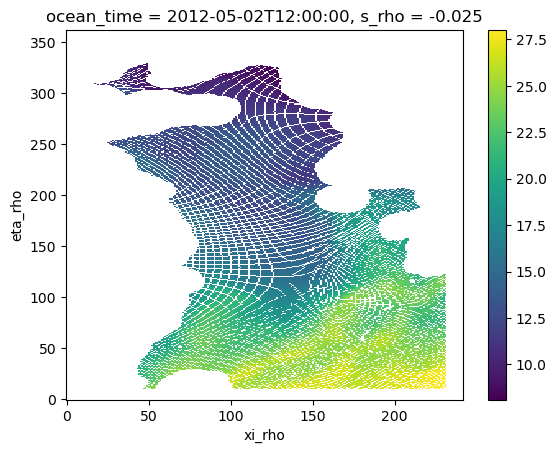

In [28]:
Obs_modgrd.isel(ocean_time=1).plot()

In [29]:
Obs_modgrd = Obs_modgrd.ffill(dim='eta_rho',limit=2)
Obs_modgrd = Obs_modgrd.ffill(dim='xi_rho',limit=2)

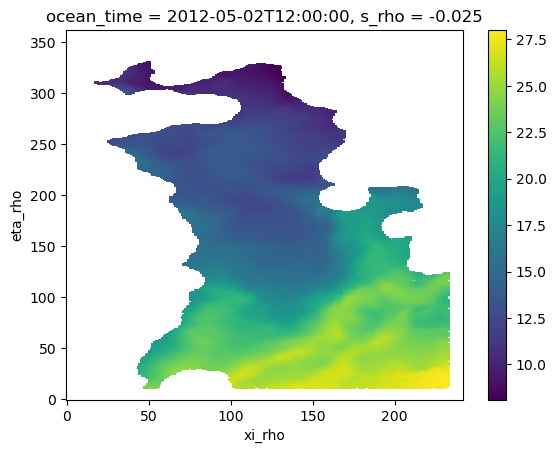

In [30]:
Obs_modgrd.isel(ocean_time=1).plot()

In [31]:
#calculate the month mean of obs
Obs_modgrd_lowcut = Obs_modgrd.copy()
# Obs_modgrd_lowcut.data[Obs_modgrd_lowcut.data<=2] = np.nan
Obs_seasonmean = Obs_modgrd.groupby('ocean_time.season').mean('ocean_time')
Obs_monthmean = Obs_modgrd.resample(ocean_time='1m').mean()

# Obs_monthmean

In [32]:
#calculate the daily mean of forward
start = time.time()
fwd_dailymean = fwd_data.resample(ocean_time='1d').mean().compute()
fwd_dailymean = fwd_dailymean.assign_coords({'ocean_time':Obs_modgrd.ocean_time.data})
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# fwd_dailymean


calculating costing 2.366068 min


In [51]:
fwd_dailymean = fwd_dailymean.where(~np.isnan(Obs_modgrd),np.nan) 

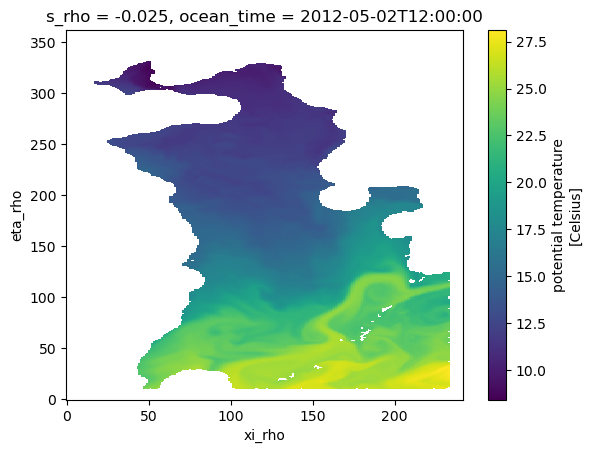

In [45]:
fwd_dailymean_obspos.isel(ocean_time=1).plot()

In [52]:
#------- calculate the daily bias of forward
fwd_dailybias = (fwd_dailymean - Obs_modgrd_lowcut)

In [53]:
#------- calculate the season mean of forward
start = time.time()
fwd_seasonmean = fwd_dailymean.groupby("ocean_time.season").mean("ocean_time").compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# fwd_dailymean

#------- calculate the season bias of forward
fwd_seasonbias = fwd_seasonmean - Obs_seasonmean

calculating costing 0.001707 min


In [ ]:
#------- calculate month mean
start = time.time()
fwd_monthmean = fwd_dailymean.resample(ocean_time='1m').mean("ocean_time").compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# fwd_monthmean

#------- calculate the monthly bias of forward
fwd_monthbias = (fwd_monthmean - Obs_monthmean)

In [ ]:
#calculate the daily mean of prior
start = time.time()
prior_dailymean =prior_data.resample(ocean_time='1d').mean().compute()
#align ocean_time with Obs
prior_dailymean = prior_dailymean.assign_coords({'ocean_time':Obs_modgrd.ocean_time.data})
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# prior_dailymean

In [ ]:
# calculate the daily bias of prior
prior_dailybias = prior_dailymean - Obs_modgrd_lowcut

In [ ]:
#------- calculate the season mean of prior
start = time.time()
prior_seasonmean = prior_dailymean.groupby("ocean_time.season").mean("ocean_time").compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))

In [ ]:
# calculate the seaon bias of prior
prior_seasonbiass = prior_seasonmean - Obs_seasonmean

In [ ]:
#calculate the month mean of prior
start = time.time()
prior_monthmean =prior_data.resample(ocean_time='1m').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# prior_monthmean
#------- calculate the monthly bias of prior
prior_monthbias = (prior_monthmean - Obs_monthmean)

In [ ]:
#calculate the daily mean of posterior
start = time.time()
post_dailymean =post_data.resample(ocean_time='1d').mean().compute()
post_dailymean = post_dailymean.assign_coords({'ocean_time':Obs_modgrd.ocean_time.data})
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# post_dailymean

In [ ]:
# calculate the daily bias of posterior
post_dailybias = post_dailymean - Obs_modgrd_lowcut

In [ ]:
#------- calculate the season mean of forward
start = time.time()
post_seasonmean = post_dailymean.groupby("ocean_time.season").mean("ocean_time").compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# fwd_dailymean

#------- calculate the season bias of forward
post_seasonbias = post_seasonmean - Obs_seasonmean

In [ ]:
#calculate the month mean of posterior
start = time.time()
post_monthmean =post_dailymean.resample(ocean_time='1m').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# post_monthmean

In [ ]:
# calculate the daily bias mean
#### true bias ######
# bias = mean(model_dailymean - observation_dailymean)
fwd_dailybiasmean = fwd_dailybias.mean(dim='ocean_time',)
prior_dailybiasmean = prior_dailybias.mean(dim='ocean_time')
post_dailybiasmean = post_dailybias.mean(dim='ocean_time')

In [ ]:
# calculate the std of daily bias
fwd_dailystd = fwd_dailybias.std(dim='ocean_time')
prior_dailystd = prior_dailybias.std(dim='ocean_time')
post_dailystd = post_dailybias.std(dim='ocean_time')

In [ ]:
# calculate the rmse of daily data
# rmse = sqrt(daily bias mean**2 + daily std **2)
fwd_dailyrmse = np.sqrt(fwd_dailybiasmean**2 + fwd_dailystd**2)
prior_dailyrmse = np.sqrt(prior_dailybiasmean**2 + prior_dailystd**2)
post_dailyrmse = np.sqrt(post_dailybiasmean**2 + post_dailystd**2)

In [ ]:
# calculate the daily correlation of foward and obs
fwd_dailycorr = xr.corr(Obs_modgrd, fwd_dailymean,dim='ocean_time')
prior_dailycorr = xr.corr(Obs_modgrd, prior_dailymean,dim='ocean_time')
post_dailycorr = xr.corr(Obs_modgrd, post_dailymean,dim='ocean_time')

In [48]:
# plot configuration
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cmaps

In [49]:

# %matplotlib

# imonth = 2 # 0st month = 5
lon_bdy = [116,136];
lat_bdy = [21,41];


bias_min=-2; bias_max=2

my_sst_color = sio.loadmat('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/'+
                           'LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_sst = cmaps.NCV_bright


my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
my_reds = LinearSegmentedColormap.from_list('div',my_div_color[10:], N = 256)

def plot_func(n,
                  var,
                  my_title=None,
                  add_cb=False,
                  my_cbar='jet', my_clabel=None,
                  my_vmin=5, my_vmax=30):
    if add_cb:
        p=var.plot(x='lon_rho',
                 y='lat_rho',
                 vmin=my_vmin,vmax=my_vmax,
                 cmap=my_cbar,
                 add_colorbar=add_cb,
                 extend='neither',
                 cbar_kwargs={'label':my_clabel},
                 transform=ccrs.PlateCarree(),
                 ax=axs[n],zorder=-2)
    else:
        p=var.plot(x='lon_rho',
                 y='lat_rho',
                 vmin=my_vmin,vmax=my_vmax,
                 cmap=my_cbar,
                 add_colorbar=add_cb,
                 # extend='neither',
                 # cbar_kwargs={'label':my_clabel},
                 transform=ccrs.PlateCarree(),
                 ax=axs[n],zorder=-2)
    axs[n].set_title(my_title)
    axs[n].add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =0.5)
    axs[n].add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    axs[n].set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    # axs[nrow,ncol].
    return p

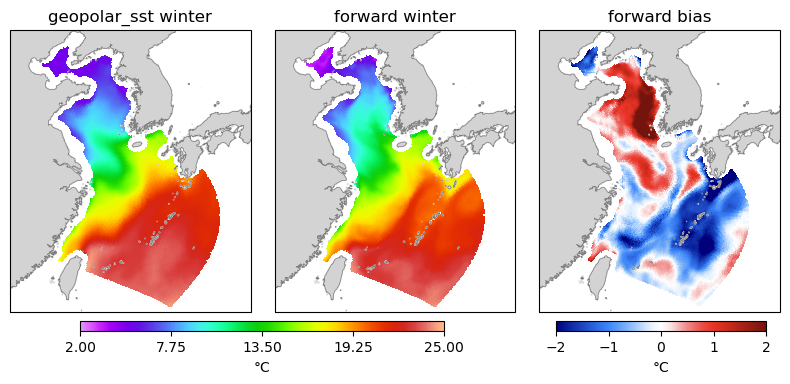

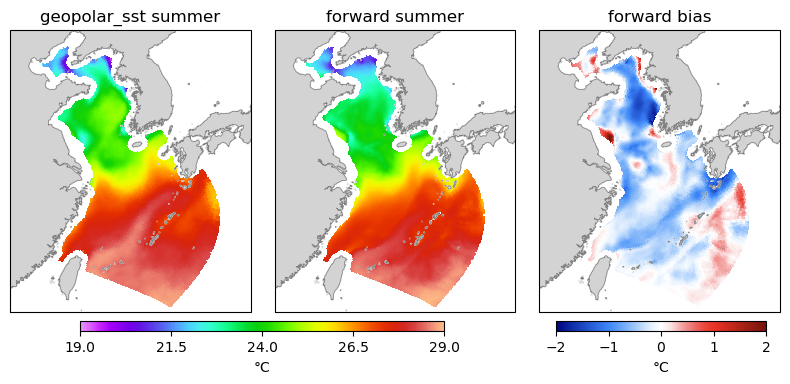

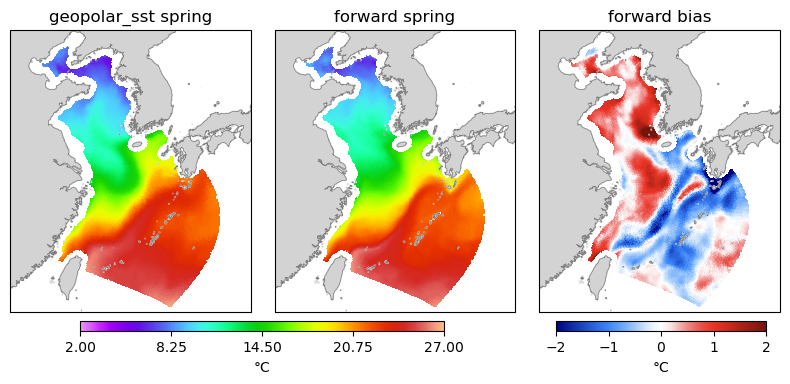

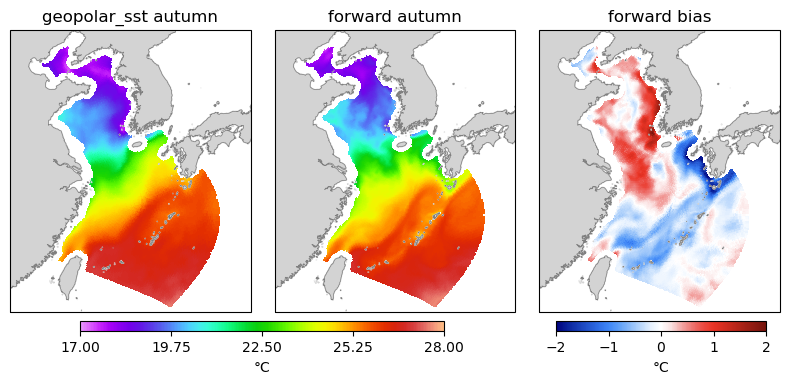

In [55]:
# seasonly data contrast
plt.close('all')
season_name = ['winter', 'summer', 'spring','autumn']
for iseason in range(len(season_name)):
    fig, axs = plt.subplots(ncols=3, nrows=1, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(14,4)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    
    this_var_min = np.round(Obs_seasonmean.isel(season=iseason).min())
    this_var_max = np.round(Obs_seasonmean.isel(season=iseason).max())
    
    plot_func(0,
              Obs_seasonmean.isel(season=iseason),
              my_title='geopolar_sst %s'%(season_name[iseason]),
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=this_var_min, my_vmax=this_var_max)
    p1=plot_func(1,
              fwd_seasonmean.isel(season=iseason),
              my_title='forward %s'%(season_name[iseason]),
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=this_var_min, my_vmax=this_var_max)
    p2 = plot_func(2,
              fwd_seasonbias.isel(season=iseason),
               my_title='forward bias',
                  # add_cb=True,
                  my_cbar=my_div,#my_clabel='std', 
                  my_vmin=bias_min, my_vmax=bias_max)
    # plot_func(2,
    #           prior_monthmean.isel(ocean_time=imonth),
    #           my_title='prior',
    #           my_cbar=my_sst,my_clabel='Celsius', 
    #           my_vmin=this_var_min, my_vmax=this_var_max)
    # plot_func(3,
    #           post_seasonmean.isel(season=iseason),
    #           my_title='posterior',
    #           my_cbar=my_sst,my_clabel='Celsius', 
    #           my_vmin=this_var_min, my_vmax=this_var_max)
    
    # plot_func(4,
    #           post_seasonbias.isel(season=iseason),
    #            my_title='post bias',
    #               # add_cb=True,
    #               my_cbar=my_div,#my_clabel='std', 
    #               my_vmin=bias_min, my_vmax=bias_max)
    position=fig.add_axes([ 0.1, 0.1,0.26, 0.025, ])
    cb = fig.colorbar(p1, cax = position,orientation='horizontal',ticks = np.linspace(this_var_min,this_var_max,5))
    cb.set_label('$\degree$C') 
    position=fig.add_axes([ 0.44, 0.1, 0.15, 0.025,])
    cb = fig.colorbar(p2, cax = position,orientation='horizontal',ticks = np.linspace(bias_min,bias_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_seasonmean/%s.jpeg'%(season_name[iseason]),bbox_inches='tight',dpi=400)
    # plt.show()
    # plt.close()
    # 

In [ ]:
# seasonly data contrast
plt.close('all')
season_name = ['winter', 'summer', 'spring','autumn']
for iseason in range(len(Obs_seasonmean)):#1):
    fig, axs = plt.subplots(ncols=2, nrows=1, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(8,4)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    
    this_var_min = np.round(Obs_seasonmean.isel(season=iseason).min())
    this_var_max = np.round(Obs_seasonmean.isel(season=iseason).max())
    
    plot_func(0,
              Obs_seasonmean.isel(season=iseason),
              my_title='geopolar_sst %s'%(season_name[iseason]),
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=this_var_min, my_vmax=this_var_max)
    p1=plot_func(1,
              fwd_seasonmean.isel(season=iseason),
              my_title='forward %s'%(season_name[iseason]),
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=this_var_min, my_vmax=this_var_max)
    # plot_func(2,
    #           prior_monthmean.isel(ocean_time=imonth),
    #           my_title='prior',
    #           my_cbar=my_sst,my_clabel='Celsius', 
    #           my_vmin=this_var_min, my_vmax=this_var_max)
    # p1=plot_func(3,
    #           post_monthmean.isel(ocean_time=imonth),
    #           my_title='posterior',
    #           my_cbar=my_sst,my_clabel='Celsius', 
    #           my_vmin=this_var_min, my_vmax=this_var_max)

    position=fig.add_axes([ 0.62, 0.174, 0.025, 0.66,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(this_var_min,this_var_max,5))
    cb.set_label('$\degree$C') 
    
    # plt.savefig('./fig_monthmean/%s.jpeg'%(imonth+5),bbox_inches='tight',dpi=400)
    # plt.show()
    # plt.close()
    # 

In [ ]:
# monthly data contrast

for imonth in range(len(Obs_monthmean)):#1):
    fig, axs = plt.subplots(ncols=4, nrows=1, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(18,4)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    
    this_var_min = np.round(Obs_monthmean.isel(ocean_time=imonth).min())
    this_var_max = np.round(Obs_monthmean.isel(ocean_time=imonth).max())
    
    plot_func(0,
              Obs_monthmean.isel(ocean_time=imonth),
              my_title='geopolar_sst',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=this_var_min, my_vmax=this_var_max)
    p1=plot_func(1,
              fwd_monthmean.isel(ocean_time=imonth),
              my_title='forward',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=this_var_min, my_vmax=this_var_max)
    # plot_func(2,
    #           prior_monthmean.isel(ocean_time=imonth),
    #           my_title='prior',
    #           my_cbar=my_sst,my_clabel='Celsius', 
    #           my_vmin=this_var_min, my_vmax=this_var_max)
    # p1=plot_func(3,
    #           post_monthmean.isel(ocean_time=imonth),
    #           my_title='posterior',
    #           my_cbar=my_sst,my_clabel='Celsius', 
    #           my_vmin=this_var_min, my_vmax=this_var_max)

    position=fig.add_axes([ 0.62, 0.174, 0.015, 0.66,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(this_var_min,this_var_max,5))
    cb.set_label('$\degree$C') 
    # plt.savefig('./fig_monthmean/%s.jpeg'%(imonth+5),bbox_inches='tight',dpi=400)
    # plt.close()
    plt.show()

In [ ]:
# monthly data bias contrast

# %matplotlib
# plot configuration

for imonth in range(len(Obs_monthmean)):#1):
    fig, axs = plt.subplots(ncols=3, nrows=1, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(12,3)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    
    plot_func(0,
              fwd_monthmean.isel(ocean_time=imonth) - Obs_monthmean.isel(ocean_time=imonth),
              my_title='forward bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    plot_func(1,
              prior_monthmean.isel(ocean_time=imonth) - Obs_monthmean.isel(ocean_time=imonth),
              my_title='prior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    p1=plot_func(2,
              post_monthmean.isel(ocean_time=imonth) - Obs_monthmean.isel(ocean_time=imonth),
              my_title='posterior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)

    position=fig.add_axes([ 0.62, 0.10, 0.02, 0.8,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min,bias_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_monthbias/%s.jpeg'%(imonth+5),bbox_inches='tight',dpi=400)
    plt.close()

In [ ]:
prior_dailymean.mean(dim='ocean_time')

In [ ]:
# daily data mean contrast
var_min = 5
var_max = 30
fig, axs = plt.subplots(ncols=2, nrows=1, 
                        subplot_kw={'projection':ccrs.Mercator()},
                        figsize=(8,4)
                       )
# fig.
#change the right to reduce the space between columns
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                    wspace=0.1, hspace=0.1)

plot_func(0,
          Obs_modgrd.mean(dim='ocean_time'),
          my_title='geopolar_sst',
          # add_cb=True,
          my_cbar=my_sst,#my_clabel='std', 
          my_vmin=var_min, my_vmax=var_max)
p1 = plot_func(1,
          fwd_dailymean.mean(dim='ocean_time'),
          my_title='forward mean',
          # add_cb=True,
          my_cbar=my_sst,#my_clabel='std', 
          my_vmin=var_min, my_vmax=var_max)
# plot_func(2,
#           prior_dailymean.mean(dim='ocean_time'),
#           my_title='prior mean',
#           # add_cb=True,#
#           my_cbar=my_sst,#my_clabel='std', 
#           my_vmin=var_min, my_vmax=var_max)
# p1=plot_func(3,
#           post_dailymean.mean(dim='ocean_time'),
#           my_title='posterior mean',
#           # add_cb=True,
#           my_cbar=my_sst,#my_clabel='std', 
#           my_vmin=var_min, my_vmax=var_max)

position=fig.add_axes([ 0.62, 0.174, 0.025, 0.66,])
cb = fig.colorbar(p1, cax = position,ticks = np.linspace(var_min,var_max,5))
cb.set_label('$\degree$C')
# plt.savefig('./fig_dailyrmse/dailymean.jpeg',
#             bbox_inches='tight',dpi=400)
# plt.close()

In [ ]:
# daily data bias contrast

fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection':ccrs.Mercator()},
                        figsize=(12,3)
                       )
# fig.
#change the right to reduce the space between columns
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                    wspace=0.1, hspace=0.1)


plot_func(0,
          fwd_dailybiasmean,
          my_title='forward bias',
          # add_cb=True,
          my_cbar=my_div,#my_clabel='std', 
          my_vmin=bias_min, my_vmax=bias_max)
plot_func(1,
          prior_dailybiasmean,
          my_title='prior bias',
          # add_cb=True,#
          my_cbar=my_div,#my_clabel='std', 
          my_vmin=bias_min, my_vmax=bias_max)
p1=plot_func(2,
          post_dailybiasmean,
          my_title='posterior bias',
          # add_cb=True,
          my_cbar=my_div,#my_clabel='std', 
          my_vmin=bias_min, my_vmax=bias_max)

position=fig.add_axes([ 0.62, 0.10, 0.02, 0.8,])
cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min,bias_max,5))
cb.set_label('$\degree$C')
# plt.savefig('./fig_dailyrmse/dailybiasmean.jpeg',
            # bbox_inches='tight',dpi=400)
# plt.close()

In [ ]:
# daily data std contrast
# std = sqrt(mean((dailybias - mean of dailybias)^2))
this_cb = cmaps.MPL_RdBu_r
fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection':ccrs.Mercator()},
                        figsize=(12,3)
                       )
# fig.
#change the right to reduce the space between columns
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                    wspace=0.1, hspace=0.1)

# plot_func(0,
#           Obs_modgrd.mean(dim='ocean_time'),
#           my_title='geopolar_sst',
#           # add_cb=True,
#           my_cbar=my_sst,#my_clabel='std', 
#           my_vmin=var_min, my_vmax=var_max)
plot_func(0,
          fwd_dailystd,
          my_title='forward error std',
          # add_cb=True,
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+1, my_vmax=bias_max)
plot_func(1,
          prior_dailystd,
          my_title='prior error std',
          # add_cb=True,#
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+2, my_vmax=bias_max)
p1=plot_func(2,
          post_dailystd,
          my_title='posterior error std',
          # add_cb=True,
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+2, my_vmax=bias_max)

position=fig.add_axes([ 0.62, 0.10, 0.02, 0.8,])
cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min+2,bias_max,5))
cb.set_label('$\degree$C')
plt.savefig('./fig_dailyrmse/dailystd.jpeg',
            bbox_inches='tight',dpi=400)
# plt.close()

In [ ]:
# daily data rmse contrast

fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection':ccrs.Mercator()},
                        figsize=(12,3)
                       )
# fig.
#change the right to reduce the space between columns
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                    wspace=0.1, hspace=0.1)

plot_func(0,
          fwd_dailyrmse,
          my_title='forward rmse',
          # add_cb=True,
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+1, my_vmax=bias_max)
plot_func(1,
          prior_dailyrmse,
          my_title='prior rmse',
          # add_cb=True,#
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+2, my_vmax=bias_max)
p1=plot_func(2,
          post_dailyrmse,
          my_title='posterior rmse',
          # add_cb=True,
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+2, my_vmax=bias_max)

position=fig.add_axes([ 0.62, 0.10, 0.02, 0.8,])
cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min+2,bias_max,5))
cb.set_label('$\degree$C')
plt.savefig('./fig_dailyrmse/dailyrmse.jpeg',
            bbox_inches='tight',dpi=400)
# plt.close()

In [ ]:
# daily data corr contrast
this_cb=sns.color_palette("Blues_r", as_cmap=True)
fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection':ccrs.Mercator()},
                        figsize=(12,3)
                       )
# fig.
#change the right to reduce the space between columns
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                    wspace=0.1, hspace=0.1)

plot_func(0,0,
          Obs_modgrd.mean(dim='ocean_time'),
          my_title='geopolar_sst',
          # add_cb=True,
          my_cbar=my_sst,#my_clabel='std', 
          my_vmin=var_min, my_vmax=var_max)
plot_func(0,1,
          fwd_dailycorr,
          my_title='forward correlation',
          # add_cb=True,
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+2.5, my_vmax=bias_max-1)
plot_func(1,0,
          prior_dailycorr,
          my_title='prior correlation',
          # add_cb=True,#
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+2.5, my_vmax=bias_max-1)
p1=plot_func(1,1,
          post_dailycorr,
          my_title='posterior correlation',
          # add_cb=True,
          my_cbar=this_cb,#my_clabel='std', 
          my_vmin=bias_min+2.5, my_vmax=bias_max-1)

position=fig.add_axes([ 0.62, 0.1075, 0.02, 0.36825,])
cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min+2.5,bias_max-1,5))
cb.set_label('non-dimensional')
plt.savefig('./fig_dailyrmse/dailycorr.jpeg',
            bbox_inches='tight',dpi=400)
# plt.close()

In [ ]:
# plot daily mean contrast 


for iday in range(data_len):
    fig, axs = plt.subplots(ncols=2, nrows=2, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    fig.text(0.48,0.87,str(prior_dailymean.ocean_time[iday].data)[0:10])
    plot_func(0,0,
              Obs_modgrd.isel(ocean_time=iday),
              my_title='geopolar_sst',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(0,1,
              fwd_dailymean.isel(ocean_time=iday),
              my_title='forward',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(1,0,
              prior_dailymean.isel(ocean_time=iday),
              my_title='prior',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    p1=plot_func(1,1,
              post_dailymean.isel(ocean_time=iday),
              my_title='posterior',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)

    position=fig.add_axes([ 0.62, 0.1075, 0.02, 0.36825,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(var_min,var_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_dailymean/%s.jpeg'%(str(prior_dailymean.ocean_time[iday].data)[0:10]),
                bbox_inches='tight',dpi=400)
    plt.close()

In [ ]:
# plot daily bias contrast 


for iday in range(data_len):
    fig, axs = plt.subplots(ncols=2, nrows=2, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    fig.text(0.48,0.87,str(prior_dailymean.ocean_time[iday].data)[0:10])
    plot_func(0,0,
              Obs_modgrd.isel(ocean_time=iday),
              my_title='geopolar_sst',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(0,1,
              fwd_dailymean.isel(ocean_time=iday) - Obs_modgrd.isel(ocean_time=iday),
              my_title='forward bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    plot_func(1,0,
              prior_dailymean.isel(ocean_time=iday) - Obs_modgrd.isel(ocean_time=iday),
              my_title='prior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    p1=plot_func(1,1,
              post_dailymean.isel(ocean_time=iday) - Obs_modgrd.isel(ocean_time=iday),
              my_title='posterior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)

    position=fig.add_axes([ 0.62, 0.1075, 0.02, 0.36825,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min,bias_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_dailybias/%s.jpeg'%(str(prior_dailymean.ocean_time[iday].data)[0:10]),
                bbox_inches='tight',dpi=400)
    plt.close()

In [ ]:
bath_ecs = fwd_ds.h.isel(ocean_time=1).data.compute()
mask_ecs = fwd_ds.mask_rho.isel(ocean_time=1).data.compute()
bath_ecs[mask_ecs == 0] = np.NaN
lon_ecs =fwd_ds.lon_rho.data.compute()
lat_ecs = fwd_ds.lat_rho.data.compute()

In [ ]:
area_range = {'bh':{'eta_range':slice(285,360),
                      'xi_range':slice(0,80)},
              
              'ys':{'eta_range': slice(220,278),
                    'xi_range':slice(70,165)},
              
              'cre':{'eta_range':slice(100,200),
                     'xi_range':slice(70,165)},
             }
                
                    

In [ ]:
import matplotlib.colors as colors
my_bath_color = cmaps.MPL_YlGnBu.colors
my_bath = LinearSegmentedColormap.from_list('lavergne',my_bath_color[-1:0:-1][:] , N = 256)
bounds = np.array([-5000,-2000,-500,-100,-25,-5])


def _forward(x):
    return -np.log(-x)


def _inverse(x):
    return -1./np.exp(x)
norm = colors.FuncNorm((_forward, _inverse), vmin=-5000, vmax=-5)

lon_bdy = [116,136];
lat_bdy = [20,42];

plt.close('all')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'k',zorder = 2,linewidth =1)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
ax.set_title('Selected Region',fontsize=12)


cp = ax.pcolormesh(lon_ecs,lat_ecs,-bath_ecs,norm = norm,cmap=my_bath,transform = ccrs.PlateCarree(),zorder=-2)
for iarea in ['bh','cre','ys']:
    if iarea == 'bh':
        abbrname = 'BH'
    elif iarea == 'ys':
        abbrname = 'YS'
    elif iarea =='cre':
        abbrname = 'CRE'
    lon_area = fwd_data.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).lon_rho.data.compute()
    lat_area = fwd_data.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).lat_rho.data.compute()

    ax.plot(lon_area[:,0], lat_area[:,0], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[:,-1], lat_area[:,-1], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[-1,:], lat_area[-1,:], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.plot(lon_area[0,:], lat_area[0,:], color = 'r',linewidth = 2,transform=ccrs.PlateCarree(),zorder = 3)
    ax.text(0.5*(lon_area[0,0]+lon_area[0,-1]),
            0.5*(lat_area[0,0]+lat_area[-1,0]),abbrname, 
            verticalalignment='center', horizontalalignment='center',
            color = 'r',fontweight='bold',
            transform=ccrs.PlateCarree(),zorder = 3)
# for i in range(0,rlon2d.shape[0],5):
#     plt.plot(rlon2d[i,:],rlat2d[i,:],color = 'grey',transform = ccrs.PlateCarree(),linewidth = 1,alpha = 0.7,zorder=0)
# for i in range(0,rlon2d.shape[1],5):
#     plt.plot(rlon2d[:,i],rlat2d[:,i],color = 'grey',transform = ccrs.PlateCarree(),linewidth = 1,alpha = 0.7,zorder=0)
position=fig.add_axes([0.85, 0.125,  0.045,0.755,])

cb = fig.colorbar(cp, cax = position, orientation='vertical',ticks = np.array([-5,-25,-100,-500,-2000,-5000]))
for bnd in position.spines.keys():
        position.spines[bnd].set_linewidth('2')
position.tick_params(direction = 'out', length =4, width = 2, labelsize = 12)
cb.set_label("Depth(m)",fontsize = 12) 
# plt.savefig('subregion_roms_ecs_new.pdf',bbox_inches='tight')
plt.savefig('subregion_roms_ecs_new.jpeg',dpi=400,bbox_inches='tight')
# plt.show()


In [ ]:
fwd_data

In [ ]:
# specific area-mean time series
Obs_areamean = {}
fwd_areamean = {}
post_areamean = {}
for iarea in ['bh','ys','cre']:
    # calculating observation
    Obs_areamean[iarea] = Obs_modgrd.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).mean(axis=(1,2),)
    # calculating forward 
    fwd_areamean[iarea] = fwd_data.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).mean(axis=(1,2)).compute()
    # # calculating prior
    # prior_areamean = prior_data.isel(eta_rho=area_range[area]['eta_range'],
    #                                  xi_rho=area_range[area]['xi_range']).mean(axis=(1,2)).compute()

    # calculating posterior
    post_areamean[iarea] = post_data.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).mean(axis=(1,2)).compute()

In [ ]:
fwd_data.lon_rho.isel(eta_rho=area_range[iarea]['eta_range'],
                                 xi_rho=area_range[iarea]['xi_range']).data.compute()

In [ ]:
# area configuration
area = 'ys'

if area == 'bh':

    lon_bdy = [116.5,123.5];
    lat_bdy = [36,42];
    fullname = 'Bohai Sea'
elif area == 'ys':

    lon_bdy = [122,128];
    lat_bdy = [34,38];
    fullname = 'Yellow Sea'
elif area =='cre':

    lon_bdy = [119.5,130.5];
    lat_bdy = [27,35];
    fullname = 'Changjiang River Esturay'

In [ ]:
# specific area-mean time series
from matplotlib.dates import DateFormatter, DayLocator
my_palette = sns.color_palette(my_div_color[5:-5])
# plt.rcParams['font.size'] = 20
# my_palette = sns.diverging_palette(250, 20, l=65, center="light")
# plt.style.use('seaborn')
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')
plt.close('all')
fig,ax = plt.subplots( figsize = (8,4),)
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
lo1, =ax.plot(Obs_areamean[area].ocean_time,Obs_areamean[area].data,
            color='k',marker='.',
            label='geopolar_sst',zorder=2)

ax.plot(fwd_areamean[area].ocean_time,fwd_areamean[area].data, 
        color=my_palette[-1],
            label='forward',
        zorder=1
           )

# ax.plot(prior_areamean.ocean_time,prior_areamean.data,
#         color=my_palette[7],
#        label='prior',
#        zorder=1)


# ax.plot(post_areamean.ocean_time,post_areamean.data,
#         color=my_palette[0],
#        label='posterior',
#        zorder=1)
ax.grid()
ax.legend(loc='upper right',fontsize=15)
ax.set_title('%s area-mean of SST'%(fullname),fontsize=15)
ax.set_ylabel('temp/$\degree$C')
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0,left=0)
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
# plt.savefig('./fig_timeseries/%s_areamean.jpeg'%(area),bbox_inches='tight',dpi=400)


In [ ]:
# specific area-daily-mean (admean) time series

# calculating observation
Obs_admean = Obs_areamean.copy()
# calculating forward 
fwd_admean = fwd_dailymean.isel(eta_rho=area_range[area]['eta_range'],
                             xi_rho=area_range[area]['xi_range']).mean(axis=(1,2)).compute()
# # calculating prior
# prior_admean = prior_dailymean.isel(eta_rho=eta_range,
#                                  xi_rho=xi_range).mean(axis=(1,2)).compute()

# # calculating posterior
# post_admean = post_dailymean.isel(eta_rho=eta_range,
#                                  xi_rho=xi_range).mean(axis=(1,2)).compute()

In [ ]:
# specific area-daily-mean (admean) time series

# plt.rcParams['font.size'] = 20
# my_palette = sns.diverging_palette(250, 20, l=65, center="light")
# plt.style.use('seaborn-whitegrid')
plt.close('all')
fig,ax = plt.subplots( figsize = (8,4),)
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')
lo1, =ax.plot(Obs_admean.ocean_time,Obs_admean.data,
            color='k',marker='.',
            label='geopolar_sst',zorder=2)

ax.plot(Obs_admean.ocean_time,fwd_admean.data, 
        marker='.',
        color=my_palette[-1],
            label='forward',
        zorder=1
           )

# ax.plot(Obs_admean.ocean_time,prior_admean.data,
#        marker='.',
#         color=my_palette[7],
#        label='prior',
#        zorder=1)


# ax.plot(Obs_admean.ocean_time,post_admean.data,
#         marker='.',
#         color=my_palette[0],
#        label='posterior',
#        zorder=1)
ax.grid()
ax.legend(loc='upper right',fontsize=15)
ax.set_title('%s area-mean of daily sst' %(fullname),fontsize=15)
ax.set_ylabel('temp/$\degree$C')
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0,left=0)

ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
# plt.savefig('./fig_timeseries/%s_admean.jpeg'%(area),bbox_inches='tight',dpi=400)


In [ ]:
# specific area daily area mean bias


# calculating forward 
fwd_areabias = (Obs_modgrd_lowcut.isel(eta_rho=area_range[area]['eta_range'],
                             xi_rho=area_range[area]['xi_range'],)
                -fwd_dailymean.isel(eta_rho=area_range[area]['eta_range'],
                             xi_rho=area_range[area]['xi_range']).data).mean(skipna=True,axis=(1,2))
# # calculating prior
# prior_areabias = (Obs_modgrd_lowcut.isel(eta_rho=eta_range,
#                              xi_rho=xi_range)
#                   -prior_dailymean.isel(eta_rho=eta_range,
#                                  xi_rho=xi_range).data).mean(skipna=True,axis=(1,2))

# # calculating posterior
# post_areabias = (Obs_modgrd_lowcut.isel(eta_rho=eta_range,
#                              xi_rho=xi_range)
#                  -post_dailymean.isel(eta_rho=eta_range,
#                                  xi_rho=xi_range).data).mean(skipna=True,axis=(1,2))

In [ ]:
np.abs(fwd_areabias.data).mean()

In [ ]:
plt.close('all')
fig,ax = plt.subplots(figsize = (10,5),
                       )
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('2')

ax.plot(fwd_areabias.ocean_time,np.abs(fwd_areabias.data), label='forward',
             marker='.',color=my_palette[-1],
           )

# ax.set_title('forward')
# ax.tick_params('x',labelbottom=False)



# ax.plot(prior_areabias.ocean_time,np.abs(prior_areabias.data), label='prior',
#         marker='.',color=my_palette[7],)

# ax.set_title('prior')
# ax.tick_params('x',labelbottom=False)


# ax.plot(post_areabias.ocean_time,np.abs(post_areabias.data),label='posterior',
#         marker='.',color=my_palette[0])
# ax.set_title('posterior')
ax.grid()
ax.set_ylabel('temp/$\degree$C')
ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0,left=0)

ax.legend(loc='upper left',fontsize=15)
ax.set_ylim([0,2.5])
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
ax.set_title('%s area-mean of daily bias' %(fullname),fontsize=15)
# plt.savefig('./fig_timeseries/%s_areabias.jpeg'%(area),bbox_inches='tight',dpi=400)


In [ ]:
# specific area daily bias mean distribution

Obs_dmean = Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).mean(skipna=True,axis=0)
fwd_dbiasmean = (fwd_dailymean.isel(eta_rho=eta_range,
                                  xi_rho=xi_range)
                 -Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).data
                ).mean(skipna=True,axis=0)

prior_dbiasmean = (prior_dailymean.isel(eta_rho=eta_range,
                                  xi_rho=xi_range)
                 -Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).data
                ).mean(skipna=True,axis=0)

post_dbiasmean = (post_dailymean.isel(eta_rho=eta_range,
                                  xi_rho=xi_range)
                 -Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).data
                ).mean(skipna=True,axis=0)


In [ ]:

plt.style.use('default')
fig, axs = plt.subplots(2,2,
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
if area == 'bh':
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                            wspace=0.1, hspace=0.1)


plot_func(0,0,
          Obs_dmean,
          my_title='geopolar_sst',
          # add_cb=True,
          my_cbar=my_sst,
          # my_clabel='Celsius', 
          my_vmin=var_min, my_vmax=var_max)
plot_func(0,1,
          fwd_dbiasmean,
          my_title='forward bias',
          # add_cb=True,
          my_cbar=my_div,
          # my_clabel='Celsius', 
          my_vmin=bias_min, my_vmax=bias_max)
plot_func(1,0,
          prior_dbiasmean,
          my_title='prior bias',
          # add_cb=True,
          my_cbar=my_div,
          # my_clabel='Celsius', 
          my_vmin=bias_min, my_vmax=bias_max)
p1=plot_func(1,1,
          post_dbiasmean,
          my_title='posterior bias',
             # add_cb=True,
          my_cbar=my_div,
             # my_clabel='Celsius', 
          my_vmin=bias_min, my_vmax=bias_max)

# position=fig.add_axes([ 0.62, 0.159, 0.02, 0.265,])
# cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min,bias_max,5))
cb.set_label('$\degree$C') 
plt.savefig('./fig_dailymean/%s_dailybiasmean.jpeg'%(area),
                bbox_inches='tight',dpi=400)

In [ ]:
corr